# Demo Resource Synchronization
Synchronization of resources means that before objects can be moved from one location to another, the processor as well as the origin and the destination resource must be available. If a resource is not available the process will wait untill the resource available.

Currently this waiting time is not recorded in the logs. The waiting time can be derived from the activity log by identifying time differences between the completion of an activity and the start of the subsequent activity.

This is an incomplete feature since preserve reservations can not be released automatically. Recommendation is to have a request_resource and a release_resource activity.

The current mechanism is based on two attributes of activities
- **keep_resources** a list of resources, which should not be released at the end of an activity
- **reserved_resources** is a dictionary, should be initialized for all activities of a process with the same variable. This will enable the transfer of reserved resources from one activity to another one.

In [1]:
import datetime, time
import simpy

import shapely.geometry

import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)


## Definition of Site

In [3]:
from_site = Site(
    env=my_env,
    name="Winlocatie",
    ID="6dbbbdf4-4589-11e9-a501-b469212bff5d",
    geometry=location_from_site,
    capacity=10,
    level=8,
)

## Definition of Vessels

In [4]:
hopper1 = TransportProcessingResource(
    env=my_env,
    name="Hopper 01",
    ID="6dbbbdf6-4589-11e9-95a2-b469212bff5b",
    geometry=location_from_site,
    loading_rate=1,
    unloading_rate=1,
    capacity=4,
    compute_v=lambda x: 10,
)

hopper2 = TransportProcessingResource(
    env=my_env,
    name="Hopper 02",
    ID="5dbbbdf6-4589-11e9-95a2-b469212bff5b",
    geometry=location_from_site,
    loading_rate=1,
    unloading_rate=1,
    capacity=4,
    compute_v=lambda x: 10,
)

## Definition of the process for hopper1
Then **requested_resources1** variable is used to initialize all activities below. This enables the transfer of reserved resources to the next activity.
The **keep_resources** parameter tells that after hopper1 has received an object from *from_site* it should not release the *from_site* resource.

In [5]:
requested_resources1 = {}
activity1 = model.ShiftAmountActivity(
    env=my_env,
    name="Transfer1",
    ID="6dbbbdf7-4589-11e9-bf3b-b469212bff52",
    registry=registry,
    processor=hopper1,
    origin=from_site,
    destination=hopper1,
    amount=1,
    duration=20,
    requested_resources=requested_resources1,
)

seq_activity1 = model.SequentialActivity(
    env=my_env,
    name="Sequential process1",
    ID="6dbbbdf7-4589-11e9-bf3b-b469212bff60",
    registry=registry,
    sub_processes=[activity1],
    requested_resources=requested_resources1,
)

while1 = model.WhileActivity(
    env=my_env,
    name="while1",
    ID="6dbbbdf7-4589-11e9-bf3b-b469212bff5g",
    registry=registry,
    sub_processes=[seq_activity1],
    requested_resources=requested_resources1,
    condition_event=[
        {
            "or": [
                {"type": "container", "concept": hopper1, "state": "full"},
                {"type": "container", "concept": from_site, "state": "empty"},
            ]
        }
    ],
)

## Definition of process for hopper2
This is a normal process without special parameters.

In [6]:
activity2 = model.ShiftAmountActivity(
    env=my_env,
    name="Transfer2",
    ID="5dbbbdf7-4589-11e9-bf3b-b469212bff52",
    registry=registry,
    processor=hopper2,
    origin=from_site,
    destination=hopper2,
    amount=1,
    duration=20,
)

seq_activity2 = model.SequentialActivity(
    env=my_env,
    name="Sequential process2",
    ID="5dbbbdf7-4589-11e9-bf3b-b469212bff60",
    registry=registry,
    sub_processes=[activity2],
)
while2 = model.WhileActivity(
    env=my_env,
    name="while2",
    ID="5dbbbdf7-4589-11e9-bf3b-b469212bff5g",
    registry=registry,
    sub_processes=[seq_activity2],
    condition_event=[
        {
            "or": [
                {"type": "container", "concept": hopper2, "state": "full"},
                {"type": "container", "concept": from_site, "state": "empty"},
            ]
        }
    ],
)

In [7]:
model.register_processes([while1, while2])
my_env.run()

In [9]:
plot.get_log_dataframe(from_site, [while2, seq_activity2, activity2, while1, seq_activity2, activity1])

,Activity,Timestamp,ActivityState,container level,geometry
0,Transfer2,1970-01-01 00:00:00,START,8.0,POINT (4.18055556 52.18664444)
1,Transfer2,1970-01-01 00:00:20,STOP,7.0,POINT (4.18055556 52.18664444)
2,Transfer1,1970-01-01 00:00:20,START,7.0,POINT (4.18055556 52.18664444)
3,Transfer1,1970-01-01 00:00:40,STOP,6.0,POINT (4.18055556 52.18664444)
4,Transfer2,1970-01-01 00:00:40,START,6.0,POINT (4.18055556 52.18664444)
5,Transfer2,1970-01-01 00:01:00,STOP,5.0,POINT (4.18055556 52.18664444)
6,Transfer1,1970-01-01 00:01:00,START,5.0,POINT (4.18055556 52.18664444)
7,Transfer1,1970-01-01 00:01:20,STOP,4.0,POINT (4.18055556 52.18664444)
8,Transfer2,1970-01-01 00:01:20,START,4.0,POINT (4.18055556 52.18664444)
9,Transfer2,1970-01-01 00:01:40,STOP,3.0,POINT (4.18055556 52.18664444)


Interesting in this scenario is that the process of hopper2 is not executed at all because hopper1 takes requests the resource *from_site* and never releases it again, thus hopper2 process can not start.

By commenting out the **keep_resource** parameter in shift amount activity of hopper1, will result in hopper1 and hopper2 getting access to the resource *from_site* one after each other.

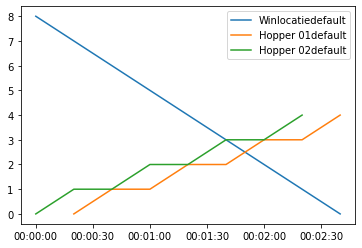

In [10]:
fig = plot.get_step_chart([from_site, hopper1, hopper2])

In [11]:
plot.vessel_planning([ hopper1, hopper2, from_site])